# Want your song to be part of Billboard Year-End Hot 100 singles?<br>ask Data Sciense.

In [3]:
import pandas as pd
from pandas import DataFrame, read_csv
import scipy as sc
import numpy as np
import seaborn as sns

import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn import metrics,tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

### Take the dataframe with all the information we collected and change him to dataframe with data that we can work good with Decision Tree algorith.

In [35]:
df_spotify=pd.read_csv("./data/spotify_after.csv")

In [36]:
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 37 columns):
Title                         512 non-null object
Artist                        512 non-null object
id                            512 non-null object
artist_genres                 512 non-null object
is_single                     512 non-null int64
total_tracks                  512 non-null int64
release_date                  512 non-null object
day_of_week                   512 non-null int64
release_season                512 non-null int64
Year                          512 non-null int64
is_top100                     512 non-null int64
acousticness                  512 non-null float64
danceability                  512 non-null float64
duration_ms                   512 non-null int64
energy                        512 non-null float64
instrumentalness              512 non-null float64
key                           512 non-null int64
liveness                      512 non-null float6

### Change the song duration from ms to minutes

In [37]:
print(df_spotify['duration_ms'].head(10))
df_spotify['duration_ms'] = round(df_spotify['duration_ms'] / 60000 , 2)
df_spotify.rename(columns={"duration_ms": "duration_min"}, inplace=True)
print(df_spotify['duration_min'].head(10))

0    233720
1    200787
2    173987
3    219320
4    202333
5    246761
6    295493
7    208373
8    236002
9    244960
Name: duration_ms, dtype: int64
0    3.90
1    3.35
2    2.90
3    3.66
4    3.37
5    4.11
6    4.92
7    3.47
8    3.93
9    4.08
Name: duration_min, dtype: float64


In [38]:
lst=df_spotify['artist_genres'].values

genres=[]
j=0
for i in lst:
    ls=i.split(',')
    if len(ls)>1:
        genres.append(ls[1].replace(" '","").replace("]","").replace("[","").replace("'",""))
    else:
        genres.append(ls[0].replace(" '","").replace("]","").replace("[","").replace("'",""))
    if genres[j]=='':
        genres[j]=pd.np.NaN
    j+=1

In [41]:
df_spotify['Genres']=genres
df_spotify['Genres'].tail()

507    post-teen pop
508        dance pop
509              rap
510        viral pop
511          pop rap
Name: Genres, dtype: object

### Give each genre his own column and mark in true/false according to the song.

In [92]:
set_temp = df_spotify['Genres']
set_temp = set(set_temp)
print(len(set_temp))
print(set_temp)

80
{' "childrens music"', 'girl group', 'san diego rap', 'melodic rap', 'latin hip hop', 'australian electropop', 'philly rap', 'basshall', 'dance pop', 'hollywood', 'country', 'hip hop', 'complextro', 'viral trap', 'chicago rap', 'miami hip hop', 'pop rock', 'atl hip hop', 'neo-singer-songwriter', 'pittsburgh rap', 'lgbtq+ hip hop', 'edm', 'uk pop', 'french indie pop', 'latin', 'new americana', 'trap', 'tropical house', 'atl trap', 'electro house', 'icelandic rock', 'canadian indie', 'southern hip hop', 'gangster rap', 'australian reggae fusion', 'dmv rap', 'latin pop', 'r&b', 'minnesota hip hop', 'electropop', 'west coast trap', 'escape room', 'israeli pop', 'acoustic pop', 'reggaeton', 'jewish pop', 'australian pop', 'viral pop', 'new orleans rap', 'funk metal', 'pop', 'la pop', 'dirty south rap', 'canadian pop', 'post-teen pop', 'christian alternative rock', 'hip pop', 'chamber pop', 'video game music', 'indie rock', 'country road', 'country pop', 'gaming edm', 'russian hip hop', '

In [96]:
set_genres = set()

for i in set_temp:
    i = i.replace('"', '').lstrip().lstrip().replace(' ','-')
    i = 'is_' + i
    set_genres.add(i)

print(len(set_genres))
print(set_genres)

80
{'is_childrens-music', 'is_tropical-house', 'is_san-diego-rap', 'is_east-coast-hip-hop', 'is_indie-rock', 'is_chamber-pop', 'is_idol', 'is_pop-rap', 'is_latin', 'is_new-americana', 'is_canadian-pop', 'is_australian-pop', 'is_electro-house', 'is_canadian-singer-songwriter', 'is_indie-poptimism', 'is_neo-singer-songwriter', 'is_icelandic-rock', 'is_west-coast-trap', 'is_house', 'is_israeli-pop', 'is_escape-room', 'is_canadian-indie', 'is_atl-hip-hop', 'is_contemporary-country', 'is_minnesota-hip-hop', 'is_dmv-rap', 'is_girl-group', 'is_latin-hip-hop', 'is_electropop', 'is_emo', 'is_edm', 'is_latin-pop', 'is_modern-rock', 'is_swedish-gangsta-rap', 'is_country', 'is_chicago-rap', 'is_atl-trap', 'is_miami-hip-hop', 'is_philly-rap', 'is_viral-pop', 'is_g-funk', 'is_pinoy-hip-hop', 'is_post-teen-pop', 'is_hip-hop', 'is_country-road', 'is_rock', 'is_jewish-pop', 'is_melodic-rap', 'is_dance-pop', 'is_viral-trap', 'is_basshall', 'is_pittsburgh-rap', 'is_indie-soul', 'is_gangster-rap', 'is_aco

In [122]:
print(df_spotify.shape)
for i in set_genres:
    df_spotify['{}'.format(i)] = 0
print(df_spotify.shape)

(507, 118)
(507, 118)


In [123]:
for i, row in df_spotify.iterrows():
    cur_genre = row['Genres']
    cur_genre = cur_genre.replace('"', '').lstrip().lstrip().replace(' ','-')
    cur_genre = 'is_' + cur_genre
    df_spotify.set_value(i, cur_genre, 1)
df_spotify['is_pop'].head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


0    1
1    1
2    0
3    0
4    0
Name: is_pop, dtype: int64

In [138]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [139]:
df_spotify=df_spotify.dropna()
len(df_spotify)

507

In [140]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [141]:
df_spotify.groupby(['Genres']).mean()

,is_single,total_tracks,day_of_week,release_season,Year,is_top100,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,words_count,stopwords_count,blobs_polarity,words_neg_count,words_pos_count,words_curse_count,avg_most_common_words_size,words_repeat_count,words_negative_pct,words_positive_pct,words_curse_pct,words_repeat_pct,stopwords_pct
Genres,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""childrens music""",1.000000,20.000000,4.000000,2.000000,2017.000000,0.000000,0.259000,0.829000,1.350000,0.886000,0.000000e+00,8.000000,0.055900,-1.746000,1.000000,0.112000,115.056000,4.000000,0.777000,1088.000000,8.000000,0.000000,0.000000,100.000000,0.000000,4.820000,60.000000,0.000000,9.190000,0.000000,5.510000,0.740000
acoustic pop,0.000000,1.000000,5.000000,4.000000,2017.000000,0.000000,0.469000,0.618000,3.310000,0.443000,0.000000e+00,2.000000,0.082900,-9.681000,1.000000,0.052600,119.949000,4.000000,0.167000,1118.000000,71.000000,0.000000,576.000000,225.000000,0.000000,5.230000,116.000000,51.520000,20.130000,0.000000,10.380000,6.350000
atl hip hop,1.000000,14.000000,5.000000,3.000000,2016.000000,0.000000,0.030700,0.417000,4.110000,0.580000,1.450000e-06,9.000000,0.179000,-4.574000,1.000000,0.207000,68.580000,5.000000,0.139000,2843.000000,252.000000,0.000000,528.000000,300.000000,33.000000,4.880000,252.000000,18.570000,10.550000,1.160000,8.860000,8.860000
atl trap,0.800000,11.800000,4.800000,2.000000,2017.200000,0.400000,0.073344,0.832000,3.308000,0.599400,0.000000e+00,4.400000,0.232400,-6.208600,0.400000,0.214220,134.265400,4.000000,0.457200,2554.400000,183.800000,0.000000,537.600000,515.000000,14.400000,5.304000,241.800000,21.426000,18.940000,0.566000,9.444000,7.200000
australian electropop,1.000000,16.000000,5.000000,1.000000,2016.000000,1.000000,0.441000,0.443000,3.890000,0.558000,0.000000e+00,0.000000,0.163000,-5.436000,1.000000,0.062400,116.838000,4.000000,0.248000,1734.000000,104.000000,0.000000,552.000000,325.000000,16.000000,5.380000,179.000000,31.830000,18.740000,0.920000,10.320000,6.000000
australian pop,1.000000,13.600000,5.000000,3.800000,2016.000000,0.400000,0.089160,0.590600,3.624000,0.764000,4.808000e-04,6.600000,0.108760,-5.191400,0.400000,0.109900,137.538600,4.000000,0.584000,1766.600000,93.800000,0.200000,748.800000,440.000000,0.200000,5.216000,171.600000,42.788000,23.250000,0.012000,9.706000,5.274000
australian reggae fusion,1.000000,6.000000,3.000000,1.000000,2017.000000,0.000000,0.285000,0.589000,5.260000,0.699000,8.110000e-05,1.000000,0.088100,-5.883000,0.000000,0.029100,145.997000,4.000000,0.496000,1230.000000,88.000000,1.000000,360.000000,475.000000,0.000000,5.070000,112.000000,29.270000,38.620000,0.000000,9.110000,7.150000
basshall,1.000000,13.000000,5.000000,3.000000,2018.000000,0.000000,0.061700,0.829000,2.850000,0.797000,0.000000e+00,5.000000,0.112000,-5.428000,1.000000,0.109000,97.972000,4.000000,0.549000,1714.000000,8.000000,0.000000,288.000000,75.000000,1.000000,5.660000,177.000000,16.800000,4.380000,0.060000,10.330000,0.470000
canadian indie,1.000000,11.000000,5.000000,1.000000,2016.000000,0.000000,0.163000,0.556000,3.390000,0.658000,0.000000e+00,0.000000,0.113000,-6.075000,1.000000,0.026500,80.529000,4.000000,0.787000,1588.000000,123.000000,0.000000,360.000000,50.000000,0.000000,5.350000,135.000000,22.670000,3.150000,0.000000,8.500000,7.750000


In [126]:
df_spotify.sort_values(by='words_curse_count')

,Title,Artist,id,artist_genres,is_single,total_tracks,release_date,day_of_week,release_season,Year,...,is_hip-pop,is_uk-pop,is_lgbtq+-hip-hop,is_french-indie-pop,is_russian-hip-hop,is_rap,is_country-pop,is_funk-metal,is_la-pop,is_gaming-edm
0,Love Yourself,Justin Bieber,3hB5DgAiMAQ4DzYbsMq1IT,"['canadian pop', 'pop', 'post-teen pop']",1,19,2015-11-13,5,3,2015,...,0,0,0,0,0,0,0,0,0,0
310,Ophelia,The Lumineers,5NORWMFC27ywGSZxi8uquP,"['folk-pop', 'modern rock', 'stomp and holler']",1,11,2016-04-08,5,1,2016,...,0,0,0,0,0,0,0,0,0,0
308,Can I Be Him,James Arthur,5ZMCXFJe9EyL9TM6PrA56U,"['pop', 'post-teen pop', 'talent show', 'uk pop']",1,18,2016-10-28,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
304,Alone,Marshmello,3MEYFivt6bilQ9q9mFWZ4g,"['brostep', 'pop', 'progressive electro house']",0,1,2016-05-13,5,1,2016,...,0,0,0,0,0,0,0,0,0,0
301,Nevermind,Dennis Lloyd,3PHjgrovCBjQQl5Np5YQBy,['israeli pop'],0,1,2016-09-18,7,3,2016,...,0,0,0,0,0,0,0,0,0,0
300,Fight Song,Rachel Platten,37f4ITSlgPX81ad2EvmVQr,"['pop', 'post-teen pop', 'viral pop']",1,12,2016-01-01,5,4,2016,...,0,0,0,0,0,0,0,0,0,0
299,The Greatest,Sia,7xHWNBFm6ObGEQPaUxHuKO,"['australian dance', 'australian pop', 'dance ...",1,19,2016-10-21,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
298,Million Reasons,Lady Gaga,7dZ1Odmx9jWIweQSatnRqo,"['dance pop', 'pop', 'post-teen pop']",1,14,2016-10-21,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
311,How Far Ill Go,Aulii Cravalho,6mb6lVLNrcUgLnEN8QnDJd,"['disney', 'hollywood', 'movie tunes', 'show t...",1,59,2016-11-18,5,3,2016,...,0,0,0,0,0,0,0,0,0,0
297,Six Feet Under,Billie Eilish,2VlLbhGLVJgdOW7kKdWWFc,"['electropop', 'pop']",0,1,2016-11-17,4,3,2016,...,0,0,0,0,0,0,0,0,0,0


In [127]:
top100 = df_spotify[df_spotify['is_top100'] == 1]
not_top100 = df_spotify[df_spotify['is_top100'] == 0]

## In the next two cells we can see the difference between the mean values of some attributes in songs that was in billboards top 100 in contrast to the song that wasn't in top.
## Also we can conclude which attributes affected on success of the song and which didn't

In [142]:
top100.describe()

,is_single,total_tracks,day_of_week,release_season,Year,is_top100,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,words_count,stopwords_count,blobs_polarity,words_neg_count,words_pos_count,words_curse_count,avg_most_common_words_size,words_repeat_count,words_negative_pct,words_positive_pct,words_curse_pct,words_repeat_pct,stopwords_pct
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.0,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,0.673611,10.774306,4.559028,2.326389,2016.645833,1.0,0.166151,0.696247,3.665937,0.630561,0.003245,5.722222,0.159446,-6.127441,0.576389,0.122368,121.600448,3.986111,0.470481,2138.843750,145.000000,0.069444,510.416667,448.090278,6.034722,5.323437,204.048611,24.665694,21.517153,0.248403,9.490451,6.820556
std,0.469708,7.367016,1.037614,1.137452,0.973293,0.0,0.192014,0.134976,0.602843,0.146973,0.023811,3.769388,0.112708,1.954020,0.494990,0.104926,29.159398,0.235702,0.199899,771.036119,57.217965,0.315738,369.283542,328.794915,10.120468,0.267404,80.470379,16.703620,14.231665,0.390762,1.117749,1.532920
min,0.000000,1.000000,1.000000,1.000000,2015.000000,1.0,0.000243,0.333000,2.030000,0.056500,0.000000,0.000000,0.021500,-15.099000,0.000000,0.023200,64.934000,3.000000,0.049900,528.000000,14.000000,-1.000000,0.000000,0.000000,0.000000,4.680000,30.000000,0.000000,0.000000,0.000000,4.970000,1.180000
25%,0.000000,1.000000,5.000000,1.000000,2016.000000,1.0,0.029025,0.611750,3.337500,0.533750,0.000000,2.000000,0.096675,-7.171250,0.000000,0.048125,98.003750,4.000000,0.339500,1590.750000,105.000000,0.000000,264.000000,243.750000,0.000000,5.150000,150.000000,13.327500,11.740000,0.000000,8.810000,6.157500
50%,1.000000,13.000000,5.000000,2.000000,2017.000000,1.0,0.087800,0.700500,3.620000,0.640500,0.000000,6.000000,0.122000,-5.816500,1.000000,0.078350,119.982000,4.000000,0.463000,1992.500000,139.000000,0.000000,432.000000,387.500000,1.000000,5.310000,187.000000,20.875000,19.605000,0.060000,9.490000,6.880000
75%,1.000000,16.000000,5.000000,3.000000,2017.000000,1.0,0.222750,0.791750,3.930000,0.743000,0.000008,9.000000,0.172000,-4.903250,1.000000,0.153750,142.291500,4.000000,0.603000,2535.000000,176.000000,0.000000,648.000000,575.000000,8.000000,5.500000,243.500000,31.882500,26.825000,0.340000,10.195000,7.895000
max,1.000000,28.000000,7.000000,4.000000,2018.000000,1.0,0.965000,0.964000,6.970000,0.928000,0.283000,11.000000,0.824000,-2.384000,1.000000,0.530000,203.911000,5.000000,0.964000,5653.000000,387.000000,1.000000,2976.000000,2450.000000,70.000000,6.290000,552.000000,110.610000,85.570000,2.420000,12.770000,10.730000


In [143]:
not_top100.describe()

,is_single,total_tracks,day_of_week,release_season,Year,is_top100,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,words_count,stopwords_count,blobs_polarity,words_neg_count,words_pos_count,words_curse_count,avg_most_common_words_size,words_repeat_count,words_negative_pct,words_positive_pct,words_curse_pct,words_repeat_pct,stopwords_pct
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.0,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.639269,10.054795,4.794521,2.456621,2016.986301,0.0,0.291632,0.648096,3.472420,0.598646,0.009639,5.264840,0.176157,-6.769973,0.515982,0.107780,119.331046,3.972603,0.427780,1751.305936,117.461187,0.100457,448.438356,385.159817,4.461187,5.302740,168.095890,26.399726,22.848128,0.205342,9.539817,6.690639
std,0.481313,7.610755,0.908051,1.032361,0.848525,0.0,0.271774,0.136638,0.878194,0.179440,0.055227,3.577862,0.130324,2.570029,0.500889,0.096662,28.663765,0.301644,0.199801,760.967692,58.942766,0.330346,317.428818,283.535343,8.623209,0.277811,77.758653,16.831269,15.580450,0.384485,1.157183,1.617588
min,0.000000,1.000000,1.000000,1.000000,2016.000000,0.0,0.000450,0.278000,1.350000,0.048500,0.000000,0.000000,0.033800,-16.986000,0.000000,0.025300,62.507000,1.000000,0.039400,300.000000,8.000000,-1.000000,0.000000,0.000000,0.000000,4.350000,21.000000,0.000000,0.000000,0.000000,3.660000,0.470000
25%,0.000000,1.000000,5.000000,2.000000,2016.000000,0.0,0.067100,0.560000,3.015000,0.496000,0.000000,1.500000,0.097200,-7.945500,0.000000,0.042050,97.997000,4.000000,0.260500,1217.000000,77.500000,0.000000,216.000000,200.000000,0.000000,5.140000,110.500000,13.855000,12.030000,0.000000,8.965000,5.870000
50%,1.000000,11.000000,5.000000,2.000000,2017.000000,0.0,0.194000,0.667000,3.360000,0.609000,0.000000,5.000000,0.117000,-6.407000,1.000000,0.062500,118.159000,4.000000,0.425000,1621.000000,109.000000,0.000000,408.000000,325.000000,0.000000,5.290000,154.000000,22.670000,19.830000,0.000000,9.560000,6.700000
75%,1.000000,15.000000,5.000000,3.000000,2018.000000,0.0,0.463500,0.746000,3.695000,0.728000,0.000032,8.000000,0.226000,-5.006000,1.000000,0.134500,138.471000,4.000000,0.558500,2108.000000,146.500000,0.000000,624.000000,512.500000,5.000000,5.490000,210.500000,37.570000,29.220000,0.275000,10.295000,7.595000
max,1.000000,59.000000,7.000000,4.000000,2018.000000,0.0,0.947000,0.935000,9.960000,0.953000,0.506000,11.000000,0.831000,-1.746000,1.000000,0.537000,203.787000,5.000000,0.931000,5651.000000,374.000000,1.000000,2064.000000,1500.000000,52.000000,6.120000,565.000000,101.530000,87.920000,3.250000,12.420000,11.320000


## From the above two cells we can conclude that the next attributes affected on success:

* is_single which means does the song has a few singers or one
* danceability
* duration of the song
* energy
* acousticness
* words_count
* stopwords_count
* words_neg_count
* words_pos_count
* words_curse_count
* words_repeat_count

## Lets group the top100 dataframe by 'Year' column and see how attributes that affect the success of a song will change in each year

In [154]:
top100_by_year=top100.groupby(['Year'])

In [155]:
top100_by_year=top100_by_year[['energy','danceability','acousticness','is_single','duration_min','words_count', 'stopwords_count', 'words_neg_count', 'words_pos_count', 'words_curse_count', 'words_repeat_count']].mean()
top100_by_year

,energy,danceability,acousticness,is_single,duration_min,words_count,stopwords_count,words_neg_count,words_pos_count,words_curse_count,words_repeat_count
Year,,,,,,,,,,,
2015,0.620449,0.645513,0.201287,0.794872,3.737949,1843.538462,131.615385,550.769231,437.179487,2.948718,172.025641
2016,0.629500,0.672864,0.172411,0.715909,3.751818,2110.431818,139.375000,561.000000,471.022727,5.204545,202.272727
2017,0.631041,0.717763,0.157285,0.608247,3.631649,2134.082474,150.515464,475.298969,453.865979,7.103093,201.628866
2018,0.637453,0.726703,0.149571,0.640625,3.555938,2365.078125,152.531250,469.500000,414.453125,7.437500,229.671875


[]

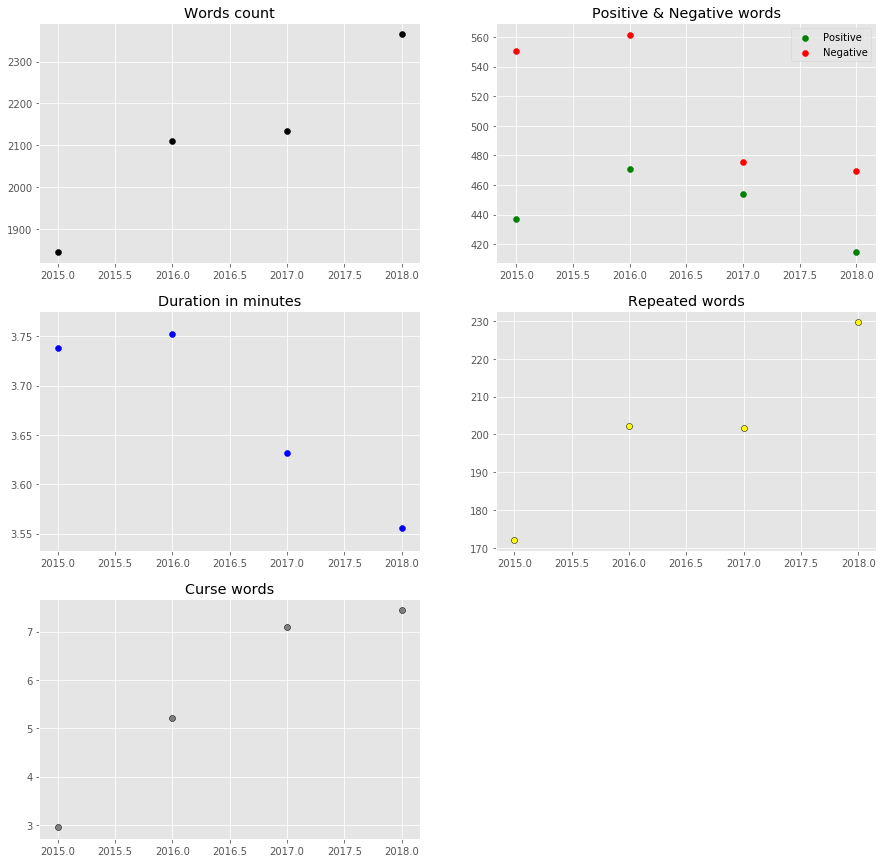

In [162]:
plt.figure(figsize=(15, 15))

plt.subplot(321)
plt.title('Words count')
plt.scatter(top100_by_year.index, top100_by_year['words_count'] ,color='black', label="data", linewidths=0.5, edgecolors='black');
plt.plot()


plt.subplot(322)

plt.title('Positive & Negative words')
plt.scatter(top100_by_year.index, top100_by_year['words_pos_count'] ,color='green', label="data");
plt.scatter(top100_by_year.index, top100_by_year['words_neg_count'] ,color='red', label="data");
plt.legend(('Positive', 'Negative'))
plt.plot()

plt.subplot(323)

plt.title('Duration in minutes')
plt.scatter(top100_by_year.index, top100_by_year['duration_min'] ,color='blue', label="data");
plt.plot()

plt.subplot(324)
plt.title('Repeated words')
plt.scatter(top100_by_year.index, top100_by_year['words_repeat_count'] ,color='yellow', label="data", linewidths=0.5, edgecolors='black');
plt.plot()

plt.subplot(325)
plt.title('Curse words')
plt.scatter(top100_by_year.index, top100_by_year['words_curse_count'] ,color='grey', label="data", linewidths=0.5, edgecolors='black');
plt.plot()

[]

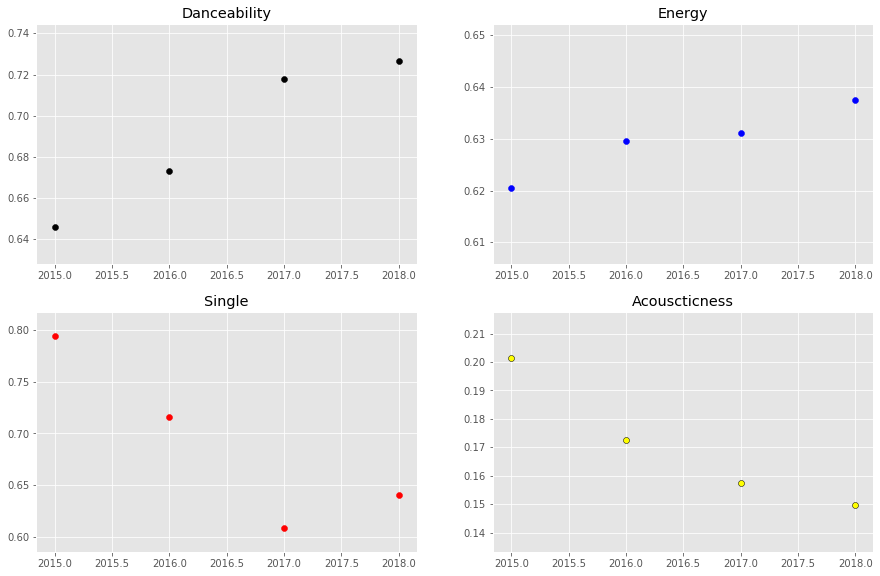

In [158]:
plt.figure(figsize=(15, 15))

plt.subplot(321)
plt.title('Danceability')
plt.scatter(top100_by_year.index, top100_by_year['danceability'] ,color='black', label="data", linewidths=0.5, edgecolors='black');
plt.plot()


plt.subplot(322)

plt.title('Energy')
plt.scatter(top100_by_year.index, top100_by_year['energy'] ,color='blue', label="data");
plt.plot()

plt.subplot(323)

plt.title('Single')
plt.scatter(top100_by_year.index, top100_by_year['is_single'] ,color='red', label="data");
plt.plot()

plt.subplot(324)
plt.title('Acouscticness')
plt.scatter(top100_by_year.index, top100_by_year['acousticness'] ,color='yellow', label="data", linewidths=0.5, edgecolors='black');
plt.plot()

In [151]:
df_spotify_by_season=df_spotify.groupby(['release_season'])

In [152]:
df_spotify_by_season=df_spotify_by_season[['is_top100']]
df_spotify_by_season

[]

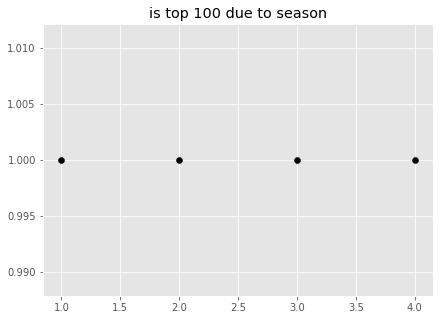

In [147]:
plt.figure(figsize=(7, 5))


plt.title('is top 100 due to season')
plt.scatter(df_spotify_by_season.index,df_spotify_by_season['is_top100'] ,color='black', label="data", linewidths=0.5, edgecolors='black');
plt.plot()

## Functions for predictable song:

### Spotify API

In [19]:
import spotipy
import spotipy.util as util
import sys
import datetime

username = 'orenxx2'
client_id = '990dc70ab060436e8439dbbdcc5055e6'
client_secret = '86603c4b2ca24ddb84f05b63fbc713a0'
redirect_uri = 'http://localhost:8888/callback/'
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_tracks()
    print("Valid Spotify token")
else:
    print("Can't get token for", username)

Valid Spotify token


In [ ]:
# empty list, batchsize and the counter for None results
def getAudioFeatures(df):
    rows = []
    batchsize = 100
    None_counter = 0

    for i in range(0,len(df['id']),batchsize):
        batch = df['id'][i:i+batchsize]
        feature_results = sp.audio_features(batch)
        for i, t in enumerate(feature_results):
            if t == None:
                None_counter = None_counter + 1
            else:
                rows.append(t)
    print('Done,\nNumber of tracks where no audio features were available:',None_counter)
    return(rows)

In [ ]:
def getSongData(track_uri):
    df = pd.DataFrame()
    tracks_info = sp.track(track_uri)
#     print(tracks_info)
#     print("\n\n\n")

    df['Title'] = [tracks_info['name']]
    df['Artist'] = tracks_info['artists'][0]['name']
    df['id'] = tracks_info['id']
    
    temp_artist_id = tracks_info['artists'][0]['id']
    df['artist_genres'] = sp.artist(temp_artist_id).get('genres')
    df['is_single'] = tracks_info['album']['album_type']
    df['total_tracks'] = tracks_info['album']['total_tracks']
    
    temp_release = tracks_info['album']['release_date']
    df['release_date'] = temp_release
    
    temp_day = datetime.datetime.strptime(temp_release, '%Y-%m-%d').strftime('%A')
    if temp_day == 'Monday':
        temp_day = 1
    elif temp_day == 'Tuesday':
        temp_day = 2
    elif temp_day == 'Wednesday':
        temp_day = 3
    elif temp_day == 'Thursday':
        temp_day = 4
    elif temp_day == 'Friday':
        temp_day = 5
    elif temp_day == 'Saturday':
        temp_day = 6
    elif temp_day == 'Sunday':
        temp_day = 7
    df['day_of_week'] = temp_day

    month = int(temp_release.split('-')[1])
    if month in [3,4,5]:
        month = 1
    elif month in [6,7,8]:
        month = 2
    elif month in [9,10,11]:
        month = 3
    elif month in [12,1,2]:
        month = 4
    df['release_season'] = month
    df['Year'] = int(temp_release.split('-')[0])
    
    return(df)

In [ ]:
# get data on song
df_data = getSongData('spotify:track:5h0Jgt873QtgL6nJRBGfT6')
print("df_data shape is: {}".format(df_data.shape))

# get audio features of the song
rows = getAudioFeatures(df_data)
df_AF = pd.DataFrame.from_dict(rows, orient='columns')
print("df_AF shape is: {}".format(df_AF.shape))

# merge between the two dataframes
df_data_AF = pd.merge(df_data, df_AF, on='id', how='inner')
print("df_data_AF shape is: {}".format(df_data_AF.shape))

df_data_AF.drop(['analysis_url', 'track_href', 'type', 'uri'], axis=1,inplace=True)
print("df_data_AF shape is: {}".format(df_data_AF.shape))

df_data_AF.head()

### Lyrics

In [4]:
one_row_df=pd.DataFrame(columns=['words_count', 'stopwords_count', 'words_pos_count','words_neg_count',
                                 'words_curse_count','words_repeat_count'])

In [5]:
def setLyricsUrl(title,artist):
    
    title=title.replace(" ","-").replace(';','').replace('(','').replace(')','').replace('.','').replace("'","").replace(',','').replace('/ ','').replace('- ','').replace('-','').replace('é','e').replace('?','').replace('"','').replace("!","").replace("in'","ing").replace(" and "," ")
    artist=artist.replace('NERD','nerd the neptunes').replace('ZAYN','zayn malik').replace('Axwell /\ Ingrosso','Axwell Ingrosso').replace('Ayo & Teo','Ayo Teo')
    url='https://www.metrolyrics.com/'+name+'-lyrics-'+artist.replace(" ","-")+'.html'
    
    return url

In [14]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, movie_reviews
import re

In [7]:
stop_words = set(stopwords.words('english'))

def remove_mystopwords(string):
    tokens = string.split(" ")
    tokens_filtered = [word for word in tokens if not word in stop_words]
    return (" ").join(tokens_filtered)

In [8]:
def count_stopwords(string):
    count=0
    tokens = string.split(" ")
    for word in tokens:
        if word in stop_words:
            count+=1
    return count 

In [9]:
all_words_count=0
stopwords_count=0

def lyrics_txt(url):
    lyrics_texts=''
    response = requests.get(url)
    data = response.text
    soup = bs(data,'html.parser')
    couplets = soup.findAll("p",{"class":"verse"})
    temp = ""
    for p in couplets:
        temp = str(temp) + str(p.text)
        temp=temp+"\n"
    #cleaning the text from unnecessary punctuation
    temp=re.sub(r'[^(a-zA-Z)\s]','', temp)
    temp=temp.replace('[','').replace(']','').replace('(','').replace(')','').replace('"','').replace("'","")
    #remove all of the digits 
    temp=''.join(j for j in temp if not j.isdigit())
    #count the number of words in each song
    all_words_count=len(temp)
    #count the number of stopwords in each song
    stopwords_count=count_stopwords(temp)
    #remove all of the stopwords
    temp = remove_mystopwords(temp)
    #for the further work with text we would like to lowercase all of the words in text   
    lyrics_texts=temp.lower()
    lyrics_texts=lyrics_texts.replace('\n ','\n')  
    return lyrics_texts    

In [10]:
count_pos=0

keywords_pos=[]

def count_pos(lyrics_texts):
    url='https://www.enchantedlearning.com/wordlist/positivewords.shtml'
    response = requests.get(url)
    data = response.text
    soup = bs(data,'html.parser')
    words = soup.findAll("div",{"class":"wordlist-section"})

    for div in words:
        divs=soup.findAll("div",{"class":"wordlist-item"})
        for div in divs:
            keywords_pos.append(div.text)


    temp=[]
    for word in keywords_pos:
        #here we create a temp list to store all the words from keywords_neg which appear in lyrics 
        temp+=re.findall(word, lyrics_texts)
    #now we'd want to know how many times these words appeared in text
    count_pos=len(temp)

    return count_pos 

In [11]:
count_neg=0

keywords_neg=[]

def count_neg(lyrics_texts):
    url='https://www.enchantedlearning.com/wordlist/negativewords.shtml'
    response = requests.get(url)
    data = response.text
    soup = bs(data,'html.parser')
    words = soup.findAll("div",{"class":"wordlist-section"})

    for div in words:
        divs=soup.findAll("div",{"class":"wordlist-item"})
        for div in divs:
            keywords_neg.append(div.text)

    for i in range (0,len(df_spotify)):
        temp=[]
        for word in keywords_neg:
            #here we create a temp list to store all the words from keywords_neg which appear in lyrics 
            temp+=re.findall(word, lyrics_texts)
        #now we'd want to know how many times these words appeared in text
        count_neg.append(len(temp))
    return count_neg 

In [17]:
count_swear=0

keywords_swear=[]

def count_swear(lyrics_texts):
    url='https://en.wiktionary.org/wiki/Category:English_swear_words'
    response = requests.get(url)
    data = response.text
    soup = bs(data,'html.parser')
    div_class = soup.findAll("div",{"class":"mw-category-group"})

    for div in div_class:
        uls=div.find_all('ul')
        for ul in uls:
            lis=ul.find_all('li')
            for ls in lis:
                links=ls.find_all('a')
                for link in links:
                    keywords_swear.append(link.text)

    keywords_swear.pop(0)         

    for k in range(0,len(keywords_swear)):
        keywords_swear[k] =keywords_swear[k].lower() 

    for i in range (0,len(df_spotify)):
        temp=[]
        for word in keywords_swear:
            #here we create a temp list to store all the words from keywords_neg which appear in lyrics 
            temp+=re.findall(word, lyrics_texts)
        #now we'd want to know how many times these words appeared in text
        count_swear=len(temp)
    return count_swear

SyntaxError: invalid syntax (<ipython-input-17-4e83e05d6107>, line 5)

In [15]:
from collections import Counter

reg = re.compile('\S{4,}')

repeated_words=0

def find_repeated_count(lyrics_texts):
    for i in range (0,len(df_spotify)):
        c = Counter(ma.group() for ma in reg.finditer(lyrics_texts))
        repeated_words=sum(c.values())


In [144]:
url=setLyricsUrl('Love You Like a Love Song','Selena Gomez')
lyrics=lyrics_txt(url)
count_positive=count_pos(lyrics)
count_negative=count_neg(lyrics)
count_curse=count_swear(lyrics)
find_repeated_count(lyrics)

NameError: name 'setLyricsUrl' is not defined

# Alisa 
# need to add the function that add Genre (single genre) column to the df

### and then run the following lines

In [18]:
set_genres = {'is_childrens-music', 'is_tropical-house', 'is_san-diego-rap', 'is_east-coast-hip-hop', 'is_indie-rock', 'is_chamber-pop', 'is_idol', 'is_pop-rap', 'is_latin', 'is_new-americana', 'is_canadian-pop', 'is_australian-pop', 'is_electro-house', 'is_canadian-singer-songwriter', 'is_indie-poptimism', 'is_neo-singer-songwriter', 'is_icelandic-rock', 'is_west-coast-trap', 'is_house', 'is_israeli-pop', 'is_escape-room', 'is_canadian-indie', 'is_atl-hip-hop', 'is_contemporary-country', 'is_minnesota-hip-hop', 'is_dmv-rap', 'is_girl-group', 'is_latin-hip-hop', 'is_electropop', 'is_emo', 'is_edm', 'is_latin-pop', 'is_modern-rock', 'is_swedish-gangsta-rap', 'is_country', 'is_chicago-rap', 'is_atl-trap', 'is_miami-hip-hop', 'is_philly-rap', 'is_viral-pop', 'is_g-funk', 'is_pinoy-hip-hop', 'is_post-teen-pop', 'is_hip-hop', 'is_country-road', 'is_rock', 'is_jewish-pop', 'is_melodic-rap', 'is_dance-pop', 'is_viral-trap', 'is_basshall', 'is_pittsburgh-rap', 'is_indie-soul', 'is_gangster-rap', 'is_acoustic-pop', 'is_australian-electropop', 'is_christian-alternative-rock', 'is_video-game-music', 'is_southern-hip-hop', 'is_australian-reggae-fusion', 'is_dirty-south-rap', 'is_complextro', 'is_pop', 'is_hollywood', 'is_neo-soul', 'is_new-orleans-rap', 'is_pop-rock', 'is_trap', 'is_reggaeton', 'is_r&b', 'is_hip-pop', 'is_uk-pop', 'is_lgbtq+-hip-hop', 'is_french-indie-pop', 'is_russian-hip-hop', 'is_rap', 'is_country-pop', 'is_funk-metal', 'is_la-pop', 'is_gaming-edm'}
type(set_genres)

set

In [ ]:
print(df.shape)
for i in set_genres:
    df['{}'.format(i)] = 0
print(df.shape)

In [ ]:
cur_genre = df['Genres']
cur_genre = cur_genre.replace('"', '').lstrip().lstrip().replace(' ','-')
cur_genre = 'is_' + cur_genre
df['{}'.format()] = cur_genre

In [140]:
df_spotify.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 0 to 511
Data columns (total 118 columns):
Title                            object
Artist                           object
id                               object
artist_genres                    object
is_single                        int64
total_tracks                     int64
release_date                     object
day_of_week                      int64
release_season                   int64
Year                             int64
is_top100                        int64
acousticness                     float64
danceability                     float64
duration_min                     float64
energy                           float64
instrumentalness                 float64
key                              int64
liveness                         float64
loudness                         float64
mode                             int64
speechiness                      float64
tempo                            float64
time_signatur

In [141]:
print(df_spotify.shape)
df_spotify = df_spotify.drop(['Title', 'Artist', 'id', 'artist_genres', 'release_date', 'Year', 'Genres'], 1)
print(df_spotify.shape)

(507, 118)
(507, 111)


In [142]:
y = df_spotify['is_top100'].values.tolist()
type(y)

list

In [144]:
XTrain, XTest, yTrain, yTest = train_test_split(df_spotify, y, test_size=0.2)

In [154]:
clf = tree.DecisionTreeClassifier()
clf.fit(XTrain, yTrain)

y_pred = clf.predict(XTest)
y_pred_train = clf.predict(XTrain)

print('Accuracy on Train data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(confusion_matrix(yTest, y_pred))

print(classification_report(yTest,y_pred))

# clf = tree.DecisionTreeClassifier()
# parameters = {'max_depth':(3,5,10), 'min_samples_split':[10, 15,20]}
# clfCV = GridSearchCV(clf, parameters, cv=10)
# clfCV.fit(X.reshape(-1,1), y)

# am=np.argmax(clfCV.cv_results_["mean_test_score"])
# print("DT")
# print("best value {} for permutation {}".format(clfCV.cv_results_["mean_test_score"][am],clfCV.cv_results_["params"][am]))

Accuracy on Train data=  1.0
Accuracy on test data=  1.0
[[42  0]
 [ 0 60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        60

   micro avg       1.00      1.00      1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

